<div style="text-align: right"> Alexander Snouffer

<div style="text-align: right"> MAE 6226

<div style="text-align: right"> May 07, 2020

# <center>MAE 6226: Final Project

# <center>Analysis of a NACA 64-206 Airfoil

## Introduction

The NACA 64-206, the airfoil used on the F16 Fighter Jet <sup> [1] </sup>, airfoil will be analyzed using the potential flow theory, which will then be compared to an airfoil solver, Xfoil. The differences between the potential flow theory model and the Xfoil model will be discussed, specifically surrounding the limitations of the potential flow theory when analyzing airfoils. 

## Derivations and Equations

### Panel Method:

The panel method that is used to analyze the NACA 64-206 airfoil creates distinct source sheets between two consecutive points on the NACA 64-206 profile. The two consecutive points are known, while the midpoint of the panel is calculated using:

$${x_c}=\frac{x_i + x_{i+1}}{2}$$

$${y_c}=\frac{y_i + y_{i+1}}{2}$$

The length of the panel is calculated using: 

$${l}=\sqrt{(x_{i+1} - x_i)^2 + (y_{i+1} - y_{i})^2}$$

And the angle of the panel is calculated using: 

$${\beta}=cos(\frac{y_{i+1} - y_i}{l})$$

The panel method setup is created into a python class that stores the ${x}$ points, the ${y}$ points, the midpoints, the length, the panel’s angle, the sheet strength ${\sigma}$, and all of the coefficients for easy access. While the ${x}$ points, ${y}$ points, the midpoints, the length, and ${\beta}$ are all calculated within the class, the sheet strength, ${\sigma}$, the tangential velocity, and all of the coefficients are calculated based on the other flow characteristics, which will be discussed later on. 


### Setting up the Flow

Once the panels are defined based on the ${x}$ and ${y}$ points of the airfoil, the actual flow that is being calculated needs to be setup. For this, the freestream velocity ${u_{inf}}$ and the angle of attack, ${\alpha}$, should be set. For this analysis, the angle of attack is going to vary between ${-8.0^{\circ}}$ and ${6.0^{\circ}}$, and the freestream flow is set to achieve Reynold’s numbers of ${50,000}$, ${100,000}$, ${250,000}$, ${500,000}$, and ${1,000,000}$. To accomplish this, a Freestream class is created, that contains both the ${u_{inf}}$ and the ${\alpha}$ values associated with them. This will be used later on when solving the linear algebra matrix equations for ${\sigma}$ to setup the freestream matrix ${b}$, which will be discussed in the following section. 

### Solving the Linear System with Kutta Condition:

Once the panels and flow characteristics are determined as described above, the flow around the airfoil can begin to be solved. First, understanding how the flow behaves at the trailing edge of the airfoil is critical. The second stagnation point of the airfoil must be exactly at the trailing edge, in order for the streamlines around the airfoil to behave in a realistic manner. This condition is known as the Kutta condition, which exactly states that the flow must leave the airfoil tangentially at the trailing edge. To accomplish this, circulation must be added to every panel to properly locate this rear stagnation point. By using the velocity potential ${\phi}$: 

$$
\begin{align*}
\phi\left(x_{c_i},y_{c_i}\right) &= V_\infty x_{c_i} \cos \alpha + V_\infty y_{c_i} \sin \alpha \\
&+ \sum_{j=1}^N \frac{\sigma_j}{2\pi} \int_j \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1}^N \frac{\gamma}{2\pi} \int_j \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

And the flow tangency boundary condition applied at every panel center, the velocity potential can be reduced to: 

$$
\begin{align*}
0 &= V_\infty \cos \left(\alpha-\beta_i\right) + \frac{\sigma_i}{2} \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

with: 

$$\frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) = \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial n_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}$$

and:

$$\frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right)= \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial n_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}$$

where:

$$x_j(s_j) = x_{b_j} - s_j \sin \beta_j$$

$$y_j(s_j) = y_{b_j} + s_j \cos \beta_j$$

$$\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i$$ 

$$\frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i$$

Next, to enforce the Kutta condition, the following has to be true: 

$$C_{p_1} = C_{p_{N}}$$

and given:

$$C_p = 1-\left(\frac{V}{U_\infty}\right)^2$$

$$V_{n_1} = V_{n_N} = 0$$

therefore:

$$V_{t_1} = V_{t_N} = 0$$

Which then implies that the tangential velocities at the two points are equal, as the normal velocities at the two points have to be ${0.0}$. Understanding this, allows us to derive the following equation for the tangential velocity, which can be used to solve for the pressure coefficient.

$$
\begin{align*}
V_{t_i} &= V_\infty \sin \left(\alpha-\beta_i\right) \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial t_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2} {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial t_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2} {\rm d}s_j \\
&-\frac{\gamma}{2}
\end{align*}
$$

where:

$$\frac{\partial x_{c_i}}{\partial t_i} = -\sin \beta_i$$ 

$$\frac{\partial y_{c_i}}{\partial t_i} = \cos \beta_i$$

Once these are known, the matrix equation can be created, with the freestream contribution being on the right hand side, while source matrix, the vortex array, and the Kutta array are combined on the left. This lets you solve for the strength, and subsequently ${\gamma}$, all of which is shown below. 

$$[A][\sigma,\gamma] = [b]$$

### Solving for Pressure, Lift, and Drag Coefficients:

Once the above linear system is solved and the flow characteristics are assigned to their respective classes, the various coefficients can be solved. First, the pressure coefficient, ${c_p}$ on ${i^{th}}$ panel, can be solved using the following equation:

$${c_p^i = 1 - (\frac{V_{t_i}}{u_{inf}}})^2$$

Then, to solve both the lift and drag coefficients, ${c_L}$ and ${c_D}$ respectively, the lift and drag, ${L}$ and ${D}$ must be solved using the following equations:

$${L = {\sum_i}{-c_p^i * sin({\beta_i}) * l_i}}$$

$${D = {\sum_i}{c_p^i * cos({\beta_i}) * l_i}}$$


Finally, using the lift and drag solved above and the chord length ${c}$, their respective coefficients can be solved using:

$${c_L = \frac{L}{c}}$$

$${c_D = \frac{D}{c}}$$

where:

$${c = x_{max} - x_{min}}$$


## Code:

 ### Importing Libraries and Predefined Functions

In [1]:
import numpy
import math
from scipy import integrate, linalg
from matplotlib import pyplot
%matplotlib inline

In [2]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = numpy.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = numpy.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient
        self.cl = 0.0 # lift coefficient
        self.cd = 0.0 # drag coefficient
        
def define_panels(x, y, N):    
    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i + 1], y[i + 1])
    
    return panels

class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)  # degrees to radians
        
def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return (((x - (panel.xa - numpy.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + numpy.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - numpy.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + numpy.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

def source_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    return A

def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    return A

def kutta_condition(A_source, B_vortex):
    
    b = numpy.empty(A_source.shape[0] + 1, dtype=float)
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b

def build_singularity_matrix(A_source, B_vortex):
    
    A = numpy.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)
    A[:-1, :-1] = A_source
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

def build_freestream_rhs(panels, freestream):
    
    b = numpy.empty(panels.size + 1, dtype=float)
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[0].beta) +
                                 numpy.sin(freestream.alpha - panels[-1].beta) )
    return b

def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):

    A = numpy.empty((panels.size, panels.size + 1), dtype=float)
    A[:, :-1] = B_vortex
    A[:, -1] = -numpy.sum(A_source, axis=1)
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
        
def compute_pressure_coefficient(panels, freestream):
    
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2
        
def compute_lift_coefficient(panels):
    lift = 0
    chord = abs(max(panel.xa for panel in panels) - min(panel.xa for panel in panels))
    for panel in panels:
        lift = lift - panel.cp * numpy.sin(panel.beta) * panel.length
        
    for panel in panels:
        panel.cl = lift / chord
        
def compute_drag_coefficient(panels):
    drag = 0
    width = abs(max(panel.xa for panel in panels) - min(panel.xa for panel in panels))
    for panel in panels:
        drag = drag + panel.cp * numpy.cos(panel.beta) * panel.length
        
    for panel in panels:
        panel.cd = drag / width

        
def calculate_Flow(x, y, u_inf = 1.0, alpha = 0.0):
    
    N = x.size - 1

    freestream = Freestream(u_inf, alpha)
    panels = define_panels(x, y, N)

    ASource = source_contribution_normal(panels)
    bVortex = vortex_contribution_normal(panels)

    A = build_singularity_matrix(ASource, bVortex)
    b = build_freestream_rhs(panels, freestream)

    strength = numpy.linalg.solve(A, b)

    for i, panel in enumerate(panels):
        panel.sigma = strength[i]

    gamma = strength[-1:]

    compute_tangential_velocity(panels, freestream, gamma, ASource, bVortex)
    compute_pressure_coefficient(panels, freestream)
    compute_lift_coefficient(panels)
    compute_drag_coefficient(panels)
       
    return panels, freestream, gamma

### Importing NACA 64-206 Airfoil Profile<sup>[1]<sup/>

In [3]:
Foil50X, Foil50Y = numpy.loadtxt('NACA64-206.csv', dtype=float, delimiter=',', unpack=True)

### Finding the Lift and Drag Coefficients over a Range of Angle of Attacks

In [4]:
alphaList = numpy.linspace(-8.0, 6.0, 33)
cl = numpy.empty_like(alphaList)
cd = numpy.empty_like(alphaList)
u_inf = 3.55175 

for i in range(0, len(alphaList)):
    panels, freestream, gamma = calculate_Flow(Foil50X, Foil50Y, u_inf, alpha = alphaList[i])
    cl[i] = panels[-1].cl
    cd[i] = panels[-1].cd

### Plotting the Results

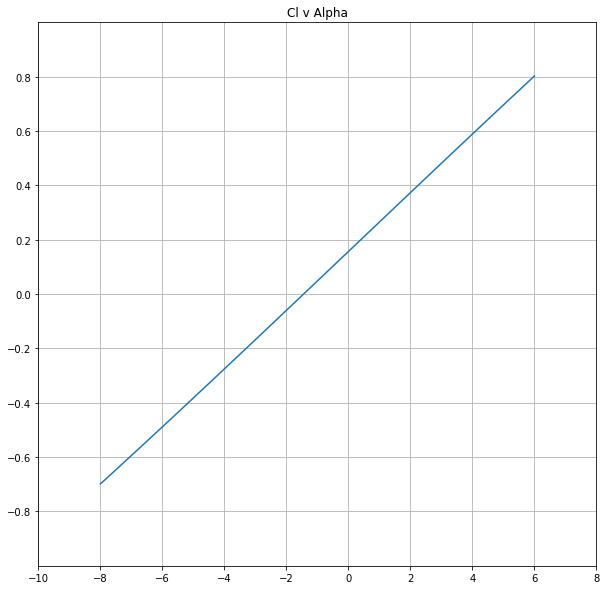

In [5]:
pyplot.figure(figsize=(10, 10));
pyplot.plot(alphaList, cl)
pyplot.xlim(-10.0, 8.0)
pyplot.ylim(-1.0, 1.0)
pyplot.xticks(numpy.arange(-10.0, 10.0, step=2.0))
pyplot.yticks(numpy.arange(-0.8, 1.0, step=0.2))
pyplot.grid()
pyplot.title('Cl v Alpha');

### Comparison to Xfoil Results <sup>[1]</sup>

<img src='ClvAoA_50k.png'>

### Plotting the Results

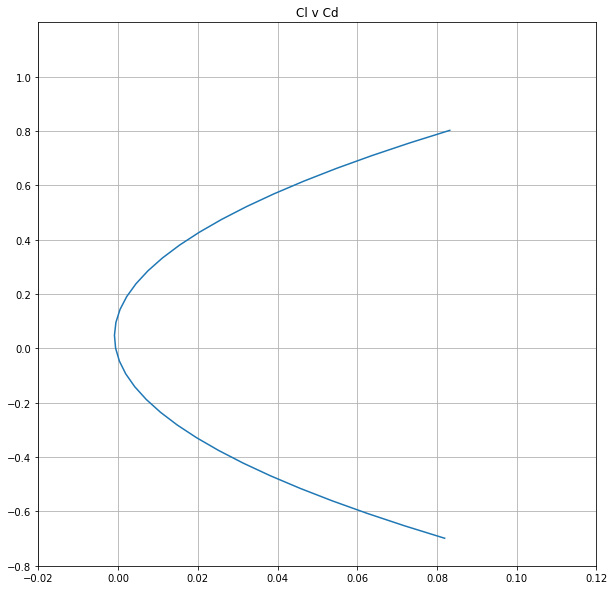

In [6]:
pyplot.figure(figsize=(10, 10));
pyplot.plot(cd, cl);
pyplot.xlim(-0.02, 0.12)
pyplot.ylim(-0.8, 1.2)
pyplot.xticks(numpy.arange(-0.02, 0.14, step=0.02))
pyplot.yticks(numpy.arange(-0.8, 1.2, step=0.2))
pyplot.grid()
pyplot.title('Cl v Cd');

### Comparison to Xfoil Results <sup>[1]</sup>

<img src='ClvCd_50k.png'>

### Plotting the Results

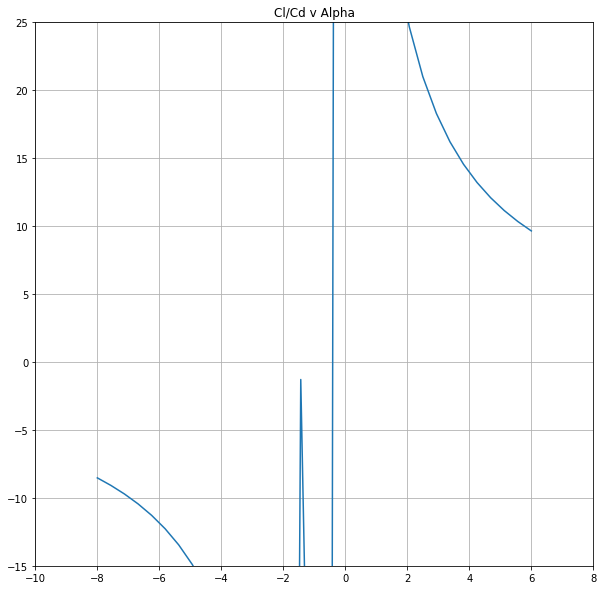

In [7]:
pyplot.figure(figsize=(10, 10));
pyplot.plot(alphaList, cl/cd);
pyplot.xlim(-10.0, 8.0)
pyplot.ylim(-15.0, 25.0)
pyplot.xticks(numpy.arange(-10.0, 10.0, step=2.0))
pyplot.yticks(numpy.arange(-15.0, 30.0, step=5.0))
pyplot.grid()
pyplot.title('Cl/Cd v Alpha');

### Comparison to Xfoil Results <sup>[1]</sup>

<img src='ClCdvAoA_50k.png'>

### Plotting the Results

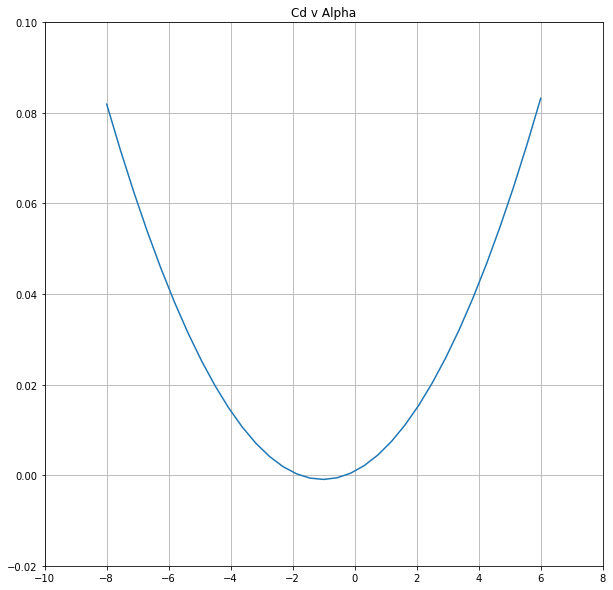

In [8]:
pyplot.figure(figsize=(10, 10));
pyplot.plot(alphaList, cd);
pyplot.xlim(-10.0, 8.0)
pyplot.ylim(-0.02, 0.1)
pyplot.xticks(numpy.arange(-10.0, 10.0, step=2.0))
pyplot.yticks(numpy.arange(-0.02, .12, step=0.02))
pyplot.grid()
pyplot.title('Cd v Alpha');

### Comparison to XFoil Results <sup>[1]</sup>

<img src='CdvAoA_50k.png'>

## Comparing Reynold's Numbers over Angle of Attack

### The Reynold's Numbers that are used are 50,000, 100,000, 250,000, 500,000 and 1,000,000

In [9]:
alphaList = numpy.linspace(-8.0, 6.0, 33)
u_infList = [3.55175, 7.1035, 14.207, 35.5175, 71.035]

cl = numpy.zeros((len(u_infList), len(alphaList)))
cd = numpy.zeros_like(cl)

for j in range(0, len(u_infList)):
    for i in range(0, len(alphaList)):
        panels, freestream, gamma = calculate_Flow(Foil50X, Foil50Y, u_inf = u_infList[j], alpha = alphaList[i])

        cl[j, i] = panels[-1].cl
        cd[j, i] = panels[-1].cd

### Plotting the Results

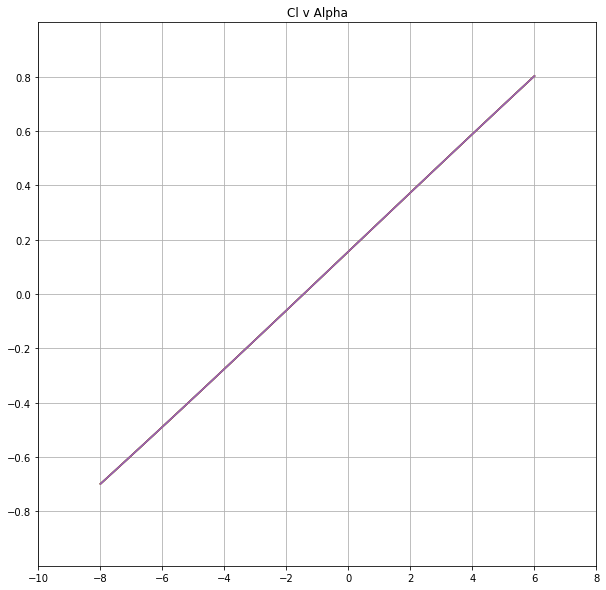

In [10]:
pyplot.figure(figsize=(10,10));
for j in range(0, len(u_infList)):
    pyplot.plot(alphaList, cl[j, :])
    pyplot.xlim(-10.0, 8.0)
    pyplot.ylim(-1.0, 1.0)
    pyplot.xticks(numpy.arange(-10.0, 10.0, step=2.0))
    pyplot.yticks(numpy.arange(-0.8, 1.0, step=0.2))
    pyplot.grid()

pyplot.title('Cl v Alpha');

### Comparison to Xfoil Results <sup>[1]</sup>

<img src='ClvAoA_All.png'>

### Plotting the Results

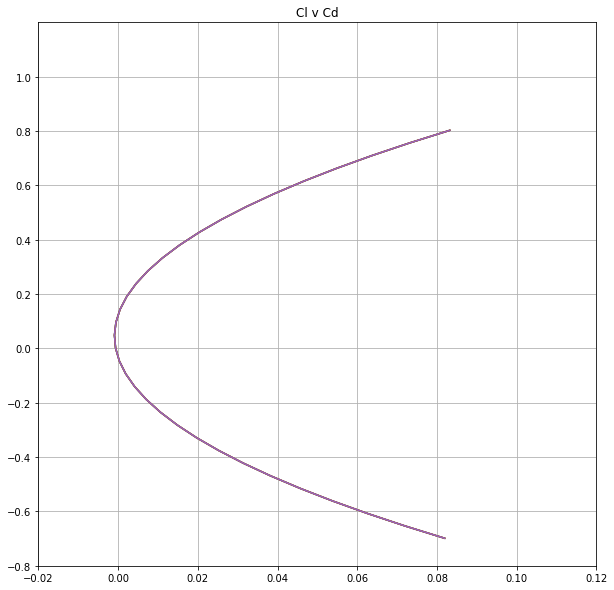

In [11]:
pyplot.figure(figsize=(10, 10));
for j in range(0, len(u_infList)):
    pyplot.plot(cd[j, :], cl[j, :])
    
pyplot.xlim(-0.02, 0.12)
pyplot.ylim(-0.8, 1.2)
pyplot.xticks(numpy.arange(-0.02, 0.14, step=0.02))
pyplot.yticks(numpy.arange(-0.8, 1.2, step=0.2))
pyplot.grid()
pyplot.title('Cl v Cd');

### Comparison to Xfoil Results <sup>[1]</sup>

<img src='ClvCd_All.png'>

### Plotting the Results

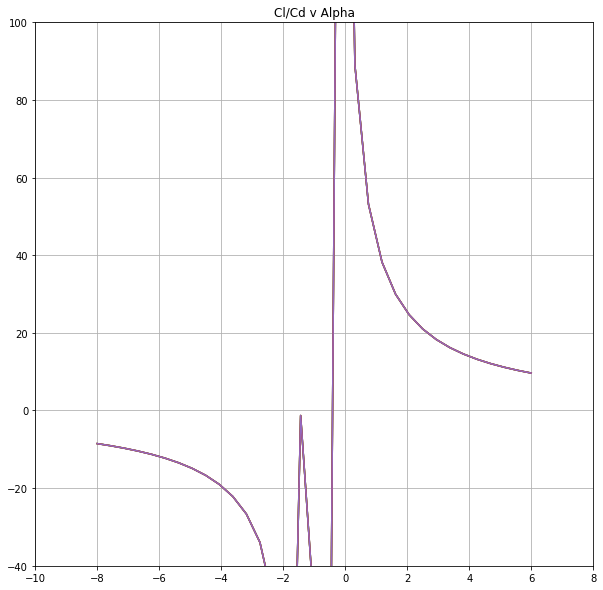

In [13]:
pyplot.figure(figsize=(10, 10));
for j in range(0, len(u_infList)):
    pyplot.plot(alphaList, cl[j, :]/cd[j, :])
    
pyplot.xlim(-10.0, 8.0)
pyplot.ylim(-40.0, 100)
pyplot.xticks(numpy.arange(-10.0, 10.0, step=2.0))
pyplot.yticks(numpy.arange(-40.0, 120.0, step=20.0))
pyplot.grid()
pyplot.title('Cl/Cd v Alpha');

### Comparison to Xfoil Results <sup>[1]</sup>

<img src='ClCdvAoA_All.png'>

### Plotting the Results

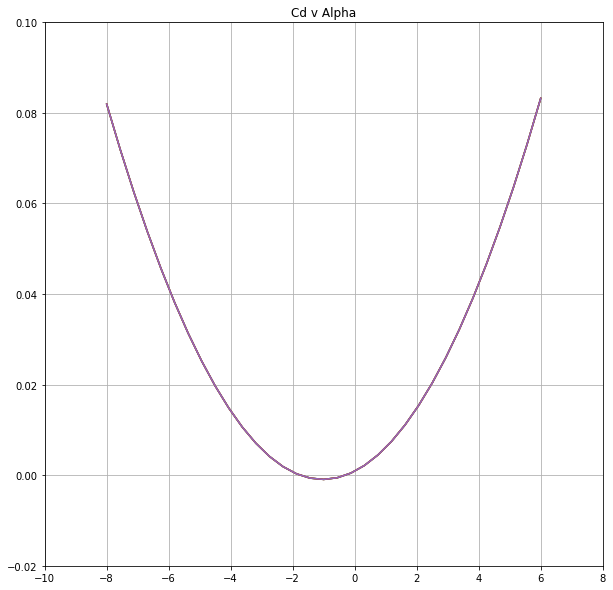

In [14]:
pyplot.figure(figsize=(10, 10));
for j in range(0, len(u_infList)):
    pyplot.plot(alphaList, cd[j, :])
    
pyplot.xlim(-10.0, 8.0)
pyplot.ylim(-0.02, 0.1)
pyplot.xticks(numpy.arange(-10.0, 10.0, step=2.0))
pyplot.yticks(numpy.arange(-0.02, .12, step=0.02))
pyplot.grid()
pyplot.title('Cd v Alpha');

### Comparison to XFoil Results <sup>[1]</sup>

<img src='CdvAoA_All.png'>

## Discussion

In looking at the results of only the ${50,000}$ Reynold’s Number plots, it is clear that there are limitations to the model that was implemented. For the ${\alpha}$ values between ${-4.0^{\circ}}$ and ${4.0^{\circ}}$, the potential flow model was on par with the XFoil predictions, varying by a vertical shift. However, outside of this range, the model begins to break down. As shown in the XFoil predictions, there is a maximum ${c_L}$ that is reached beyond ${8.0^{\circ}}$. The model that was implemented was unable to capture this, as it predicted a pure linear increase as ${\alpha}$ was increased. Furthermore, for the range ${-2.0^{\circ}}$ and ${0.0^{\circ}}$, the drag coefficient becomes negative, and is predicted to be ${0.0}$ twice, as shown in the plots above. This obviously could not take place, and causes two discontinuities on the ${\frac{c_L}{c_D} vs. \alpha}$ plot. XFoil, on the other hand did not predict a negative or zero ${c_D}$, so there are no discontinuities in any of their results. All in all, the model predictions would be acceptable and usable with the understanding where the model begins to break down past certain ${\alpha}$ values, as well as the discontinuity with the ${c_D}$.

Additionally, in looking at the results of the ${5}$ Reynold’s Number tests, the clear difference between the models begins to appear. As shown in all of the above plots, XFoil is predicting similar, but not identical results for the various Reynold’s Numbers. In contrast, the potential flow theory model, has not changed from the first ${RE = 50,000}$ test. Though the only results that are drastically different are the ${c_D}$ and therefore the ${\frac{c_L}{c_D} vs. \alpha}$ plot, these are still significant differences that must be understood. As XFoil predicts, the higher the Reynold’s Number, the lower the drag coefficient, which intuitively makes sense. However, as the potential flow model already has an issue in this range, the model is unable to capture this behavior at higher Reynold’s Numbers.  


## Conclusion

As shown above, there are some limitations to the potential flow theory model that was used to compute the flow characteristics around a NACA 64-206 airfoil. In using the potential flow theory, there are certain bounds that must be completely understood prior to accepting the results. As the ${c_D}$ becomes both negative and ${0.0}$ for certain values, the results in this range should not be trusted completely. Furthermore, beyond certain ${\alpha}$ values, the ${c_L}$ does not reach a maximum or minimum value. Without reaching these maxima or minima, the ${c_L}$ will eventually reach physically impossible values. Though these limitations do exist, the potential flow model does have a range of usable values that do correspond with the XFoil predictions. Overall, within this range, the potential flow model produces numerically acceptable results. 

## Sources

[1] NACA 64-206 (naca64206-il). [Online]. Available: http://airfoiltools.com/airfoil/details?airfoil=naca64206-il. [Accessed: 06-May-2020].